In [1]:
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

2023-12-15 11:19:29.214313: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 11:19:29.268572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 11:19:30.348364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber
# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

In [3]:
# Load integrated scene
# scene = load_scene("./Single Box/Single Box.xml") # Try also sionna.rt.scene.etoile
scene = load_scene(sionna.rt.scene.etoile) # Try also sionna.rt.scene.etoile

2023-12-15 11:19:32.916027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 260 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:92:00.0, compute capability: 8.6


In [4]:
'''# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")



# Add transmitter instance to scene
tx_object = scene.get("tx")
if tx_object is not None:
    scene.remove("tx")
# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27])
scene.add(tx)

rx_object = scene.get("rx")
if rx_object is not None:
    scene.remove("rx")
rx = Receiver(name="rx",
              position=[60,50,1.5],
              orientation=[0,0,0])
scene.add(rx)
tx.look_at(rx)
'''

'# Configure antenna array for all transmitters\nscene.tx_array = PlanarArray(num_rows=1,\n                             num_cols=1,\n                             vertical_spacing=0.5,\n                             horizontal_spacing=0.5,\n                             pattern="tr38901",\n                             polarization="V")\n\n# Configure antenna array for all receivers\nscene.rx_array = PlanarArray(num_rows=1,\n                             num_cols=1,\n                             vertical_spacing=0.5,\n                             horizontal_spacing=0.5,\n                             pattern="dipole",\n                             polarization="V")\n\n\n\n# Add transmitter instance to scene\ntx_object = scene.get("tx")\nif tx_object is not None:\n    scene.remove("tx")\n# Create transmitter\ntx = Transmitter(name="tx",\n                 position=[8.5,21,27])\nscene.add(tx)\n\nrx_object = scene.get("rx")\nif rx_object is not None:\n    scene.remove("rx")\nrx = Receiver(name="

In [5]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")



# Add transmitter instance to scene
pos = [-160,36,10]
tx_object = scene.get("tx")
if tx_object is not None:
    scene.remove("tx")
# Create transmitter
tx = Transmitter(name="tx",
                 position=pos)
scene.add(tx)

rx1_object = scene.get("rx1")
if rx1_object is not None:
    scene.remove("rx1")
# Create a receiver
rx_tmp = Receiver(name="rx1",
              position=[-8,-10,1.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx_tmp)

tx.look_at(rx_tmp) # Transmitter points towards receiver
rx_object = scene.get("rx")
if rx_object is not None:
    scene.remove("rx")
rx = Receiver(name="rx",
              position=pos)
scene.add(rx)
rx.look_at(rx_tmp)
scene.remove("rx1")


In [6]:
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [7]:
paths = scene.compute_paths(max_depth=3,num_samples=1e6,los=True,reflection=True,scattering=False,diffraction=False)
paths.normalize_delays = False

In [8]:
scene.preview(paths=paths,show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [9]:
a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

Shape of tau:  (1, 1, 1, 16)


Text(0, 0.5, '$|a|$')

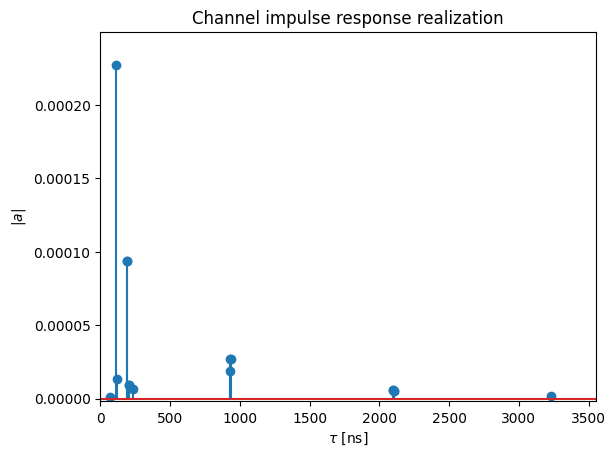

In [10]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
t = t[a_abs!=0]
a_abs = a_abs[a_abs!=0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


In [11]:
'''num_ut = 1
num_bs = 1
num_ut_ant = 1
num_bs_ant = 1
num_streams_per_tx = num_ut_ant
rx_tx_association = np.array([[1]])
sm = StreamManagement(rx_tx_association, num_streams_per_tx)'''

'num_ut = 1\nnum_bs = 1\nnum_ut_ant = 1\nnum_bs_ant = 1\nnum_streams_per_tx = num_ut_ant\nrx_tx_association = np.array([[1]])\nsm = StreamManagement(rx_tx_association, num_streams_per_tx)'

In [12]:
'''fft_size = 700
cp_length = 6
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=fft_size,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=cp_length,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])'''

'fft_size = 700\ncp_length = 6\nrg = ResourceGrid(num_ofdm_symbols=14,\n                  fft_size=fft_size,\n                  subcarrier_spacing=15e3,\n                  num_tx=1,\n                  num_streams_per_tx=num_streams_per_tx,\n                  cyclic_prefix_length=cp_length,\n                  num_guard_carriers=[5,6],\n                  dc_null=True,\n                  pilot_pattern="kronecker",\n                  pilot_ofdm_symbol_indices=[2,11])'

In [13]:
subcarrier_num = 15000
subcarrier_spacing = 15e3
frequencies = subcarrier_frequencies(subcarrier_num, subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)
ebno_db = 30

In [14]:
# channel_freq = ApplyOFDMChannel(add_awgn=True)

In [15]:
'''num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.5 # Code rate
l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)'''

'num_bits_per_symbol = 2 # QPSK modulation\ncoderate = 0.5 # Code rate\nl_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)\nn = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits\nk = int(n*coderate) # Number of information bits\n\n# The binary source will create batches of information bits\nbinary_source = BinarySource()\n\n# The encoder maps information bits to coded bits\nencoder = LDPC5GEncoder(k, n)\n\n# The mapper maps blocks of information bits to constellation symbols\nmapper = Mapper("qam", num_bits_per_symbol)\n\n# The resource grid mapper maps symbols onto an OFDM resource grid\nrg_mapper = ResourceGridMapper(rg)\n\n# The zero forcing precoder precodes the transmit stream towards the intended antennas\nzf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)\n\n# OFDM modulator and demodulator\nmodulator = OFDMModulator(rg.cyclic_prefix_length)\ndemodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)\n\n# This function remo

In [16]:
'''batch_size = 50
perfect_csi = False # Change to switch between perfect and imperfect CSI

# Compute the noise power for a given Eb/No value.
# This takes not only the coderate but also the overheads related pilot
# transmissions and nulled carriers
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)
# x_rg,g = zf_precoder([x_rg, h_freq])
y = channel_freq([x_rg, h_freq, no])
if perfect_csi:
    # For perfect CSI, the receiver gets the channel frequency response as input
    # However, the channel estimator only computes estimates on the non-nulled
    # subcarriers. Therefore, we need to remove them here from `h_freq`.
    # This step can be skipped if no subcarriers are nulled.
    h_hat, err_var = h_freq, 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))'''

'batch_size = 50\nperfect_csi = False # Change to switch between perfect and imperfect CSI\n\n# Compute the noise power for a given Eb/No value.\n# This takes not only the coderate but also the overheads related pilot\n# transmissions and nulled carriers\nno = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)\n\nb = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])\nc = encoder(b)\nx = mapper(c)\nx_rg = rg_mapper(x)\n# x_rg,g = zf_precoder([x_rg, h_freq])\ny = channel_freq([x_rg, h_freq, no])\nif perfect_csi:\n    # For perfect CSI, the receiver gets the channel frequency response as input\n    # However, the channel estimator only computes estimates on the non-nulled\n    # subcarriers. Therefore, we need to remove them here from `h_freq`.\n    # This step can be skipped if no subcarriers are nulled.\n    h_hat, err_var = h_freq, 0.\nelse:\n    h_hat, err_var = ls_est ([y, no])\n\nx_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])\nllr = demapper([x_hat, no_eff])\nb

2023-12-14 19:56:19.169010: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6969df0


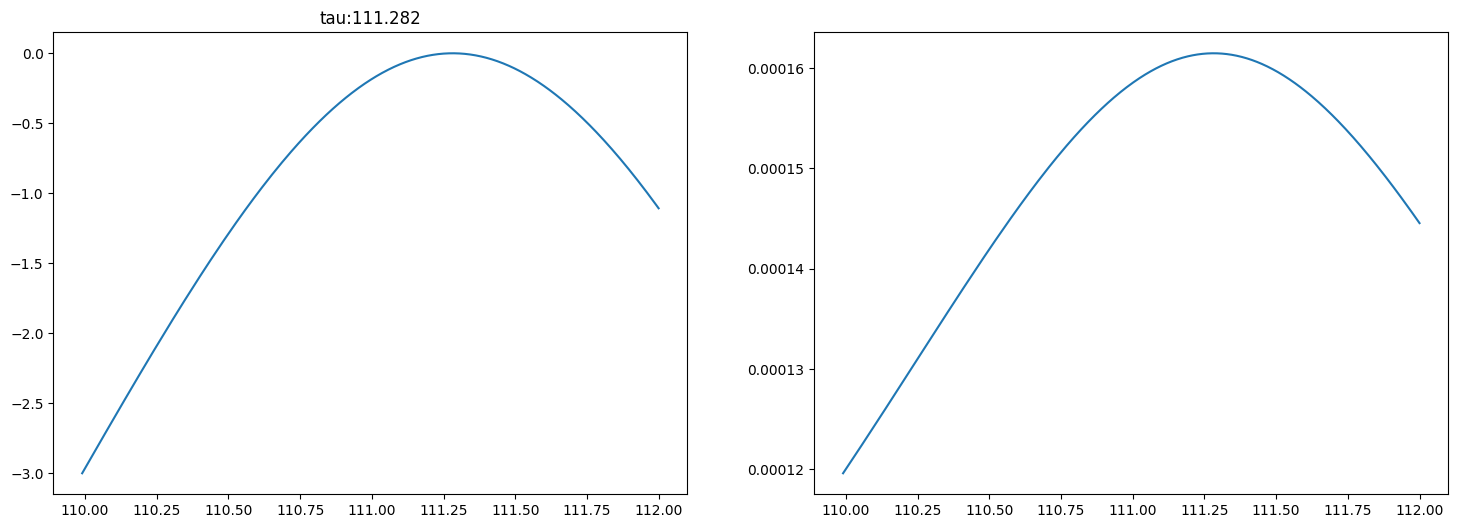

In [17]:
start = 109.99
end = 112.0
step = 0.001
y_i = h_freq[0,...]
y_i = tf.squeeze(y_i)
y_i = tf.expand_dims(y_i, axis=0)
y_i_H = tf.transpose(tf.math.conj(y_i))
y_conv = tf.matmul(y_i_H, y_i)
eig_vals, eig_vecs = tf.linalg.eigh(y_conv)
tau_range = np.arange(start,end, step)
frequencies_c = tf.cast(frequencies, dtype=tf.complex64)

P_tau_array = tf.TensorArray(dtype=tf.complex64, size=len(tau_range))
G_n = tf.cast(eig_vecs[:,:-1], dtype=tf.complex64)
G_n_H = tf.math.conj(tf.transpose(G_n))
for idx in range(len(tau_range)):
    a_m = tf.expand_dims(tf.math.exp(-1j * 2 * np.pi * frequencies_c * (tau_range[idx]/1e9)), axis=0)
    a_m_H = tf.math.conj(tf.transpose(a_m))
    P_tau_array = P_tau_array.write(idx, 1 / (a_m @ G_n @ G_n_H @ a_m_H))

P_tau = P_tau_array.stack()
# 计算谱函数
P_tau_real, P_tau_imag = tf.math.real(P_tau), tf.math.imag(P_tau)
P_abs = tf.math.sqrt(P_tau_real**2 + P_tau_imag**2)
P_norm = 10 * tf.math.log(P_abs / tf.reduce_max(P_abs), 10)
P_norm = tf.squeeze(P_norm)
max_idx = tf.argmax(P_norm)
# 绘制
# 调整画布大小
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(tau_range, tf.squeeze(P_norm))
plt.title(f"tau:{(start + int(max_idx) * step)}")
plt.subplot(1, 2, 2)
plt.plot(tau_range, tf.squeeze(P_abs))

In [28]:
snr = ebno_db
bandwidth = subcarrier_num*subcarrier_spacing
H=a[0,0,0,0,0,:,0]
H=H[H!=0]
H_H = np.conj(H)
l = len(H)
B = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
B_inv = tf.linalg.inv(B)
B_diag = tf.linalg.diag_part(B_inv)
crb1 = tf.abs(tf.cast(B_diag,tf.complex128)) / tf.cast((8 * np.pi**2 * snr * scene.frequency **2),tf.float64)

In [19]:
B

<tf.Tensor: shape=(16, 16), dtype=complex64, numpy=
array([[ 8.90922644e-13+2.04237356e-21j,  7.60851798e-12+1.02462067e-11j,
         8.71612713e-11+1.30618745e-11j,  8.71681061e-11+1.30193877e-11j,
        -1.22739167e-12+1.74092685e-11j, -3.82872935e-11-2.10599829e-10j,
         5.36433658e-12-1.70909470e-13j,  5.36433528e-12-1.70909429e-13j,
         1.87295457e-11-1.75231721e-11j,  8.00387317e-13+5.76750236e-12j,
         2.45409595e-11-6.89420179e-12j, -5.20199725e-12-6.98690281e-12j,
        -5.19834436e-12-6.98922127e-12j,  5.58859762e-13+4.53231853e-12j,
         5.58859979e-13+4.53232027e-12j,  2.43687279e-14+1.51636310e-12j],
       [ 7.60851798e-12-1.02462075e-11j,  1.82815318e-10+2.80438712e-18j,
         8.94581353e-10-8.90864049e-10j,  8.94151087e-10-8.91305474e-10j,
         1.89736268e-10+1.62791738e-10j, -2.74901435e-09-1.35820211e-09j,
         4.38460934e-11-6.31530384e-11j,  4.38460830e-11-6.31530245e-11j,
        -4.15770855e-11-3.65050989e-10j,  7.31654806e-11+4.

In [20]:
#CRB 2
import math
alpha=paths.a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau=tau[alpha!=0]
alpha=alpha[alpha!=0]
tau_complex = tf.cast(tau, tf.complex64)
# e = tf.exp(1j*2*tf.cast(np.pi,tf.complex64)*tf.cast(scene.frequency,tf.complex64)*tau_complex)
# alpha = alpha * e
length = len(alpha)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
alpha_ij = tf.reshape(alpha, (length,1)) @ tf.reshape(alpha, (1,length))
one = tf.ones((length,length))
F_alpha= 2*snr*tf.math.abs(alpha_ij)/(tau_i_mul_j**2)
F_cos = (one+4*(np.pi**2)*(scene.frequency) * tau_i_mul_j)*tf.math.cos(2*np.pi*scene.frequency*tau_i_mine_j)
F_sin = 2*np.pi*scene.frequency*tau_i_mine_j*tf.math.sin(2*np.pi*scene.frequency*tau_i_mine_j)
F = F_alpha*(F_cos+F_sin)
crb_F = tf.linalg.inv(F)
crb2 = tf.linalg.diag_part(crb_F)

In [21]:
#CRB 3
snr = ebno_db
H=a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau = tau[H!=0]
H = H[H!=0]
H_H = np.conj(H)
length = len(H)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
B_1 = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
one = tf.ones((length,length))
real = one + 4*(np.pi**2)*(scene.frequency **2) * tau_i_mul_j
img = 2*np.pi*scene.frequency *tau_i_mine_j
B_2 = tf.complex(real, img)
B_total = tf.abs(B_1*B_2)
B_total = B_total/(tau_i_mul_j**2)
crb3 = tf.linalg.diag_part(tf.linalg.inv(tf.abs(B_total)))

In [22]:
crb4 = 1/(8*np.pi**2 * bandwidth**2 * snr) * 1e18

In [29]:
# 选出a最大对应的tau的下标
c = 3e8
crb1 = tf.math.abs(crb1)
crb2 = tf.math.abs(crb2)
crb3 = tf.math.abs(crb3)
a_sortidx = np.argsort(np.abs(a[0,0,0,0,0,:,0]))
H_sortidx = np.argsort(np.abs(H))
tau_true = tf.squeeze(tau)[a_sortidx[-1]] * 1e9
tau_est = (start + int(max_idx) * step)
mse = (((tau_true - tau_est))**2)
crb1_ = crb1[H_sortidx[-1]]
crb2_ = crb2[H_sortidx[-1]] * 1e18
# crb2_ = tf.math.reduce_mean(crb2)
crb3_ = crb3[H_sortidx[-1]] * 1e18
# crb3_ = tf.math.reduce_mean(crb3)
print
print(f"range_true: {tau_true/1e9*c:.6f}m\nrange_est: {tau_est/1e9*c:.6f}m\nerror: {np.abs(tau_true-tau_est)/1e9*c:.6f}m \nmse: {mse}\ncrb1: {crb1_}\ncrb2: {crb2_}\ncrb3: {crb3_}\ncrb4: {crb4}")
print(f"\ntau_true:{tau_true} us\ntau_est:{tau_est} us")

range_true: 33.372124m
range_est: 33.384600m
error: 0.012474m 
mse: 0.0017289129318669438
crb1: 9.24215385829125e-09
crb2: 3.9761616790201515e-06
crb3: 0.002999138319864869
crb4: 0.008339192069328212

tau_true:111.24041748046875 us
tau_est:111.282 us
